Braden Anderson and Hien Lam  
DS7333: Quantifying the World, Fall 2022
# <center> <u>Case Study 2</u>
Your case study is to build a classifier using logistic regression to predict hospital readmittance. There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PowerTransformer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import StratifiedKFold

from diabetes_case_study import *

In [2]:
diabetes = pd.read_csv('dataset_diabetes/diabetic_data.csv')
id_map = pd.read_csv('dataset_diabetes/IDs_mapping.csv')

# Preprocess
- `id_map` contains mapping to three columns in `diabetes` dataset: `admission_type_id`, `discharge_disposition_id`, `admission_source_id`. Will separate them into 3 dfs and join to diabetes df for eda purposes
- convert ? to nan
- drop column with 90% NAN
- drop columns with single values
- check if there are any duplicated columns
- decide imputation methods for necessary columns


In [3]:
pd.set_option('display.max_columns', None)
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
diabetes.shape

(101766, 50)

In [5]:
id_map.head(15)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped
8,NaN,NaN
9,discharge_disposition_id,description


In [6]:
id_map.shape

(67, 2)

## Clean id_map and map to diabetes df

In [7]:
admission_type_id = id_map.iloc[0:9].rename(columns={"description" : "admission_type_desc"})
admission_type_id["admission_type_id"] = admission_type_id["admission_type_id"].astype(float)


discharge_disposition_id = id_map.iloc[10:41].rename(columns={"admission_type_id":"discharge_disposition_id",
                                                             "description" : "discharge_desc"})
discharge_disposition_id["discharge_disposition_id"] = discharge_disposition_id["discharge_disposition_id"].astype(float)


admission_source_id = id_map.iloc[42:67].rename(columns={"admission_type_id":"admission_source_id",
                                                        "description" : "admission_source_desc"})
admission_source_id["admission_source_id"] = admission_source_id["admission_source_id"].astype(float)

In [8]:
def get_code_map(df, code_col, desc_col):
    return {code:desc for code, desc in zip(df[code_col], df[desc_col])}

# Map admission type id to its description, creating new admission_type_desc column
admit_type_map = get_code_map(df=admission_type_id, 
                              code_col="admission_type_id", 
                              desc_col="admission_type_desc")
diabetes["admission_type_desc"] = [admit_type_map[code] for code in diabetes["admission_type_id"]]


# Map discharge dispo id to its description, creating new discharge_desc column
discharge_map = get_code_map(df=discharge_disposition_id, 
                             code_col="discharge_disposition_id", 
                             desc_col="discharge_desc")
diabetes["discharge_desc"] = [discharge_map[code] for code in diabetes["discharge_disposition_id"]]

# Map admission source id to its description, creating new admission_source_desc column
admit_source_map = get_code_map(df=admission_source_id, 
                                code_col="admission_source_id", 
                                desc_col="admission_source_desc")
diabetes["admission_source_desc"] = [admit_source_map[code] for code in diabetes["admission_source_id"]]

In [9]:
diabetes["admission_type_desc"] = diabetes["admission_type_desc"].fillna(value="Unknown")
diabetes["discharge_desc"] = diabetes["discharge_desc"].fillna(value="Unknown")
diabetes["admission_source_desc"] = diabetes["admission_source_desc"].fillna(value="Unknown")

for column in ["discharge_desc", "admission_type_desc", "admission_source_desc"]:
    print(f"Column: {column}, Number of NAs:{diabetes[column].isna().sum()}")

Column: discharge_desc, Number of NAs:0
Column: admission_type_desc, Number of NAs:0
Column: admission_source_desc, Number of NAs:0


In [10]:
#discharge_disposition_id
#diabetes.loc[diabetes["discharge_disposition_id"]==18,:]
#admission_source_id
#diabetes.loc[diabetes["admission_source_id"]==17,:].shape
#admission_type_id
#diabetes.loc[diabetes["admission_type_id"]==6,:].shape

In [11]:
id_desc_cols = ["admission_type_id", "admission_type_desc", 
                "discharge_disposition_id", "discharge_desc", 
                "admission_source_id", "admission_source_desc"]

diabetes.loc[:, id_desc_cols].head(10)

,admission_type_id,admission_type_desc,discharge_disposition_id,discharge_desc,admission_source_id,admission_source_desc
0,6,Unknown,25,Not Mapped,1,Physician Referral
1,1,Emergency,1,Discharged to home,7,Emergency Room
2,1,Emergency,1,Discharged to home,7,Emergency Room
3,1,Emergency,1,Discharged to home,7,Emergency Room
4,1,Emergency,1,Discharged to home,7,Emergency Room
5,2,Urgent,1,Discharged to home,2,Clinic Referral
6,3,Elective,1,Discharged to home,2,Clinic Referral
7,1,Emergency,1,Discharged to home,7,Emergency Room
8,2,Urgent,1,Discharged to home,4,Transfer from a hospital
9,3,Elective,3,Discharged/transferred to SNF,4,Transfer from a hospital


## NAs, single values, duplicates

In [12]:
# Figure out columns with missing values
missing_cols = [col for col in diabetes.columns if "?" in diabetes[col].unique()]
for col in missing_cols:
    diabetes.loc[diabetes[col]=="?", col] = np.nan

C:\Users\Braden\AppData\Local\Temp\ipykernel_14848\481901093.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  missing_cols = [col for col in diabetes.columns if "?" in diabetes[col].unique()]


In [13]:
# Percentage of NA values. Drop `weight`
diabetes.isna().sum()[diabetes.isna().sum() > 0]/diabetes.shape[0]*100

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [14]:
diabetes["max_age"] = diabetes["age"].map({"[0-10)":10, 
                                           "[10-20)":20, 
                                           "[20-30)":30, 
                                           "[30-40)":40, 
                                           "[40-50)":50, 
                                           "[50-60)":60, 
                                           "[60-70)":70, 
                                           "[70-80)":80, 
                                           "[80-90)":90, 
                                           "[90-100)":100})
diabetes.drop(columns="age", inplace=True)
diabetes.drop(columns="weight", inplace=True)

In [15]:
# Remove columns with single values
single_vals = diabetes.columns[diabetes.eq(diabetes.iloc[0]).all()].tolist()
print(f"There are {len(single_vals)} columns with single values: {single_vals}")
print(f"Original data dimiension: {diabetes.shape}")
diabetes.drop(columns=single_vals, inplace=True)
print(f"Final data dim after dropping aforementioned columns: {diabetes.shape}")
print(f"There are {diabetes.isna().sum().sum()} NA values and {diabetes.duplicated().sum()} duplicated records")

There are 2 columns with single values: ['examide', 'citoglipton']
Original data dimiension: (101766, 52)
Final data dim after dropping aforementioned columns: (101766, 50)
There are 94280 NA values and 0 duplicated records


## EDA

In [16]:
diabetes.dtypes.value_counts()

object    36
int64     14
dtype: int64

In [17]:
diabetes.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_age
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,70.967022
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,15.940838
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,10.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,60.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,70.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,80.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,100.000000


In [18]:
diabetes.describe(exclude=np.number)

,race,gender,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_desc,admission_source_desc
count,99493,101766,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,4,4,2,2,2,2,2,2,3,8,26,17
top,Caucasian,Female,MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
freq,76099,54708,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,47383,101060,101753,101765,101764,101765,54755,78363,54864,53990,60234,57494


In [19]:
model_df = diabetes.drop(columns=['admission_type_desc', 'discharge_desc', 'admission_source_desc']).copy(deep=True)

keep_diag1 = model_df["diag_1"].value_counts(normalize=True).sort_values(ascending=True).index.to_numpy()[:10]
model_df.loc[~model_df["diag_1"].isin(keep_diag1),"diag_1"] = "Other"
model_df.drop(columns=["diag_2", "diag_3"], inplace=True)

In [20]:
columns_with_missings = model_df.isna().sum()[model_df.isna().sum() > 0].index.tolist()
columns_with_missings

['race', 'payer_code', 'medical_specialty']

In [21]:
model_df.loc[:,columns_with_missings]

,race,payer_code,medical_specialty
0,Caucasian,NaN,Pediatrics-Endocrinology
1,Caucasian,NaN,NaN
2,AfricanAmerican,NaN,NaN
3,Caucasian,NaN,NaN
4,Caucasian,NaN,NaN
...,...,...,...
101761,AfricanAmerican,MC,NaN
101762,AfricanAmerican,MC,NaN
101763,Caucasian,MC,NaN
101764,Caucasian,MC,Surgery-General


In [22]:
model_df.dtypes.value_counts()

object    31
int64     14
dtype: int64

In [23]:
model_df["readmitted"].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [24]:
model_df.select_dtypes(include=object).head()

,race,gender,payer_code,medical_specialty,diag_1,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,NaN,Pediatrics-Endocrinology,Other,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,NaN,NaN,Other,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,NaN,NaN,Other,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,NaN,NaN,Other,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,NaN,NaN,Other,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [25]:
#cols = ["A1Cresult", "metformin", 'metformin-pioglitazone', "glipizide-metformin", "metformin-rosiglitazone"]
#diabetes.loc[:,cols]

In [26]:
# TODO: pipeline without encoder, plot after imputing

# numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
#                                    ('scaler', PowerTransformer(method="yeo-johnson"))])

# nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
#                                    ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])

# numeric_features = ["diag_1", "diag_2", "diag_3"]
# nominal_cat_feats = ["race", "payer_code", "medical_specialty"]

# preprocess = ColumnTransformer(transformers=[("numeric_feats", numeric_pipeline, selector(dtype_include=int)), 
#                                              ("nom_cat_feats", nominal_pipeline, selector(dtype_include=object))],
#                                remainder="passthrough",
#                                sparse_threshold=0.3)

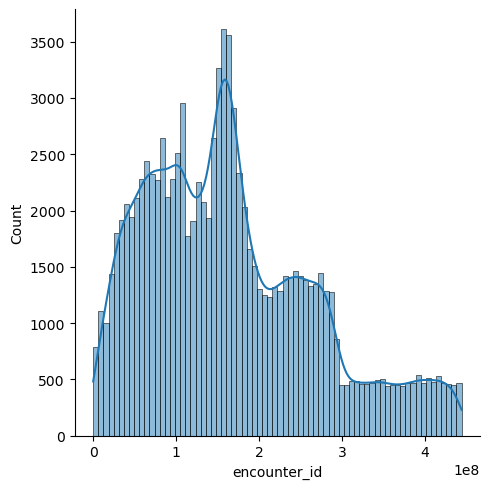

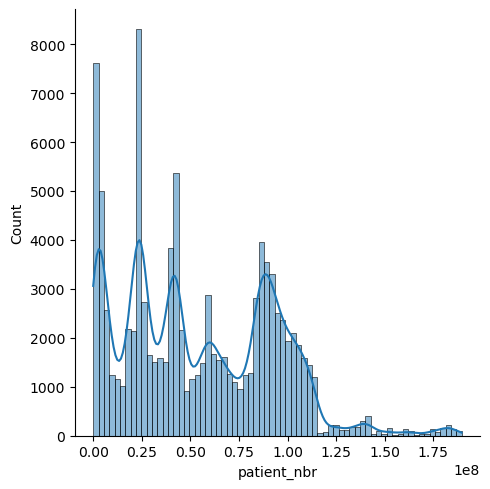

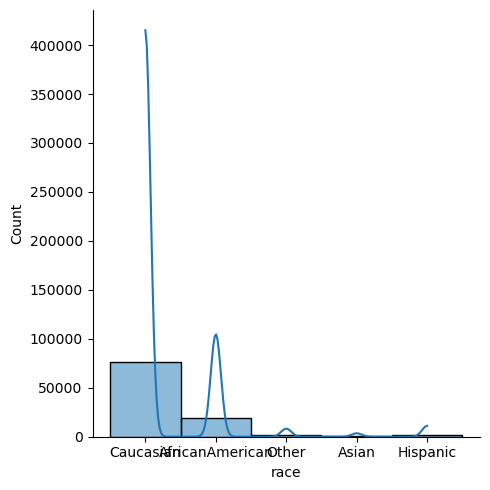

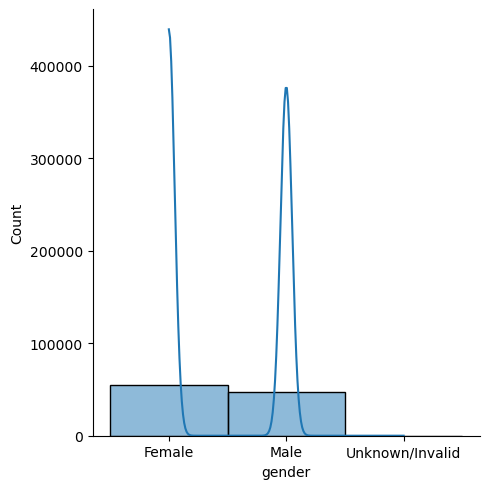

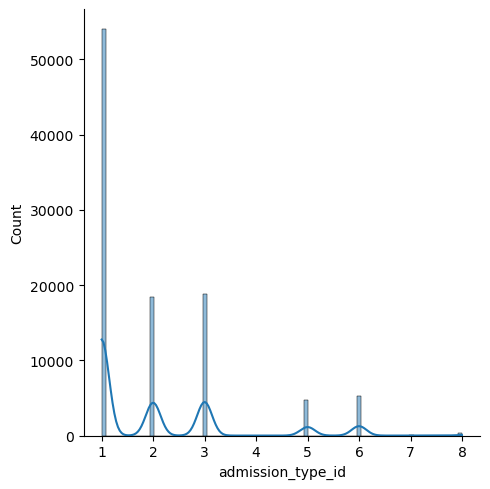

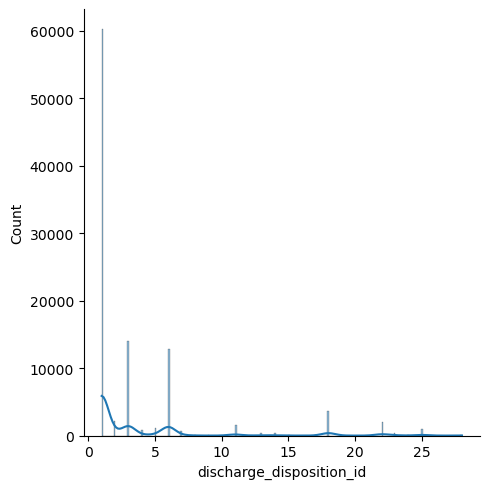

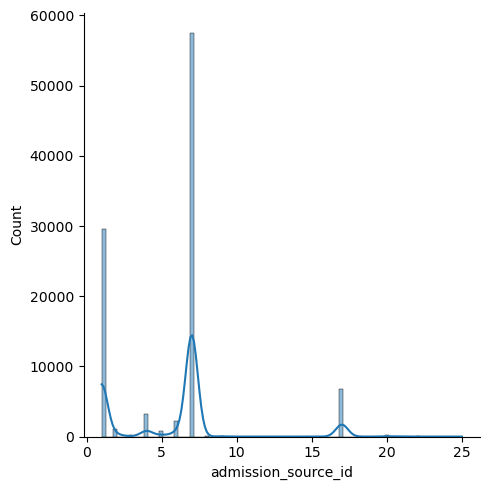

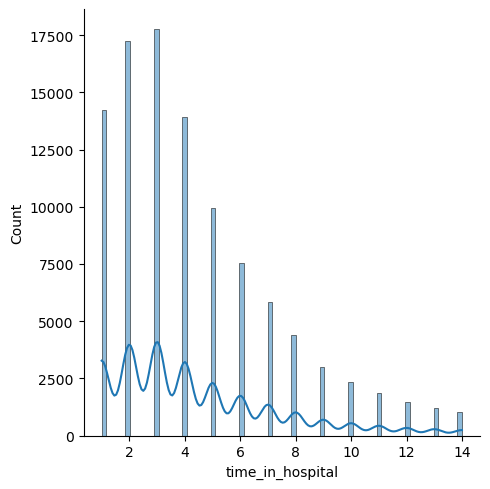

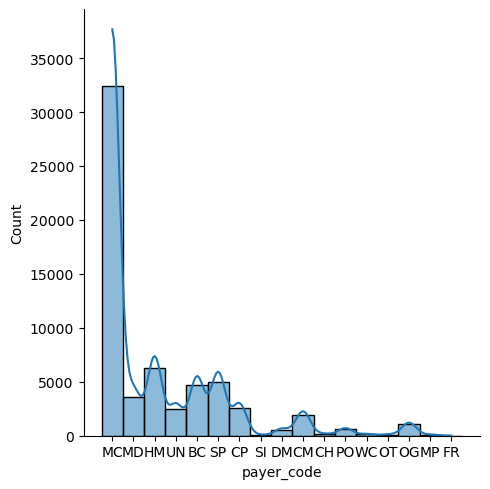

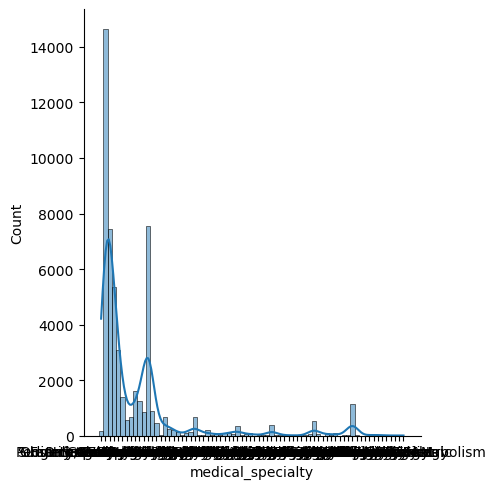

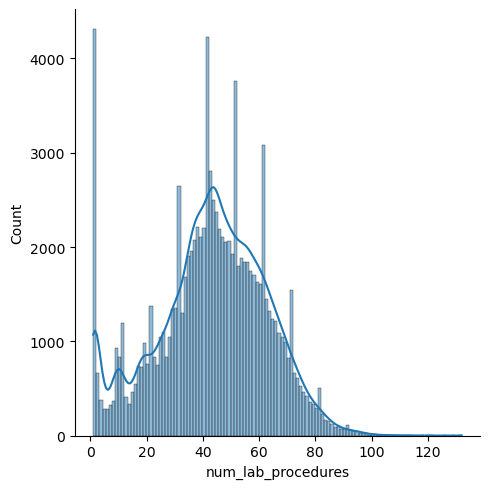

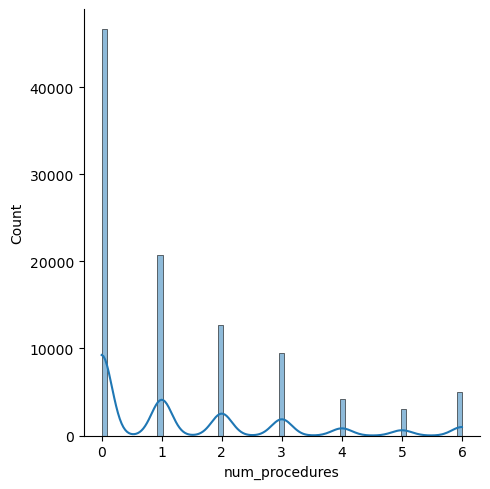

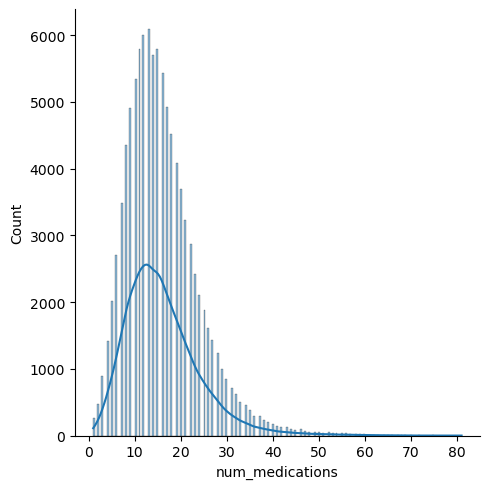

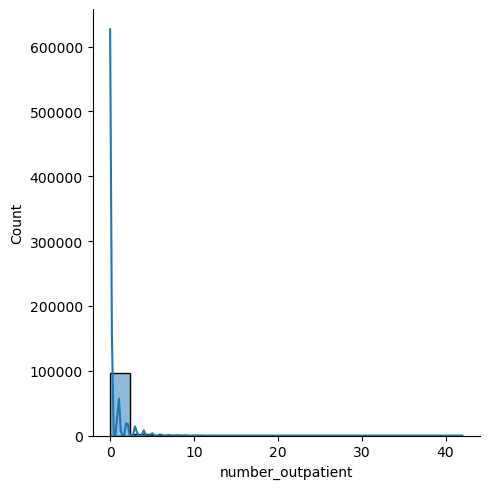

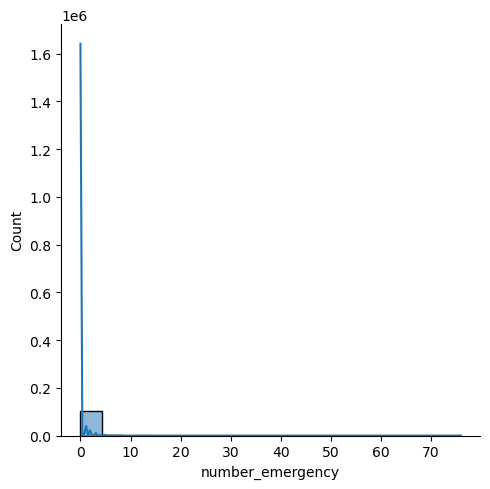

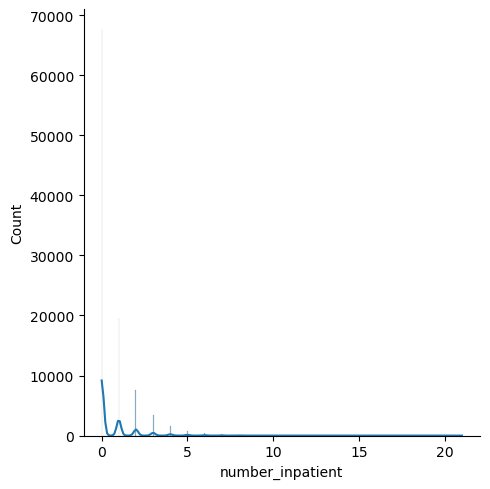

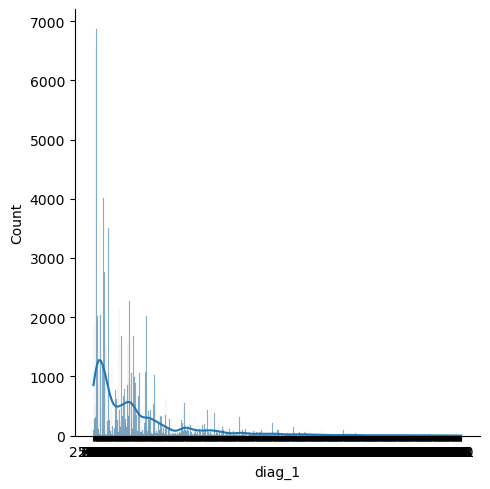

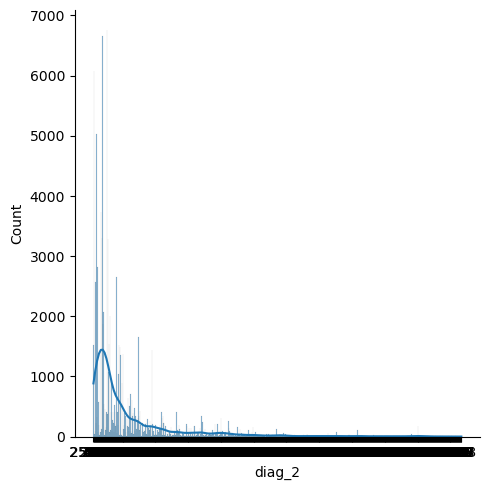

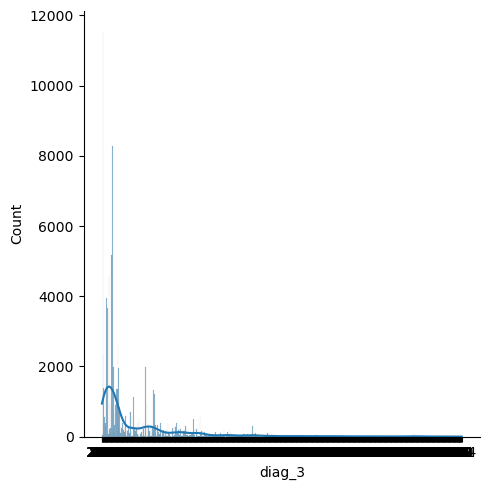

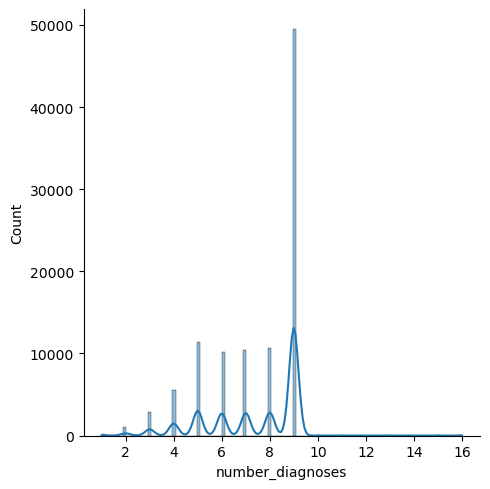

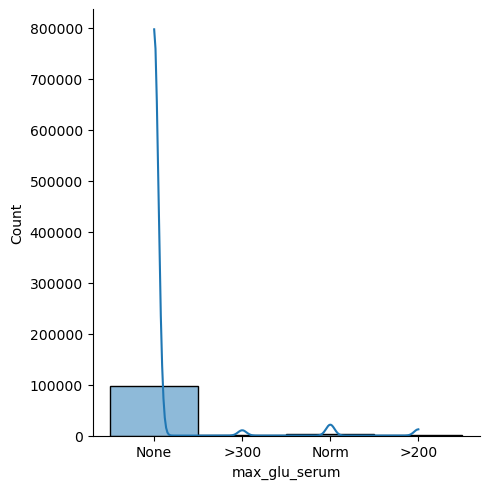

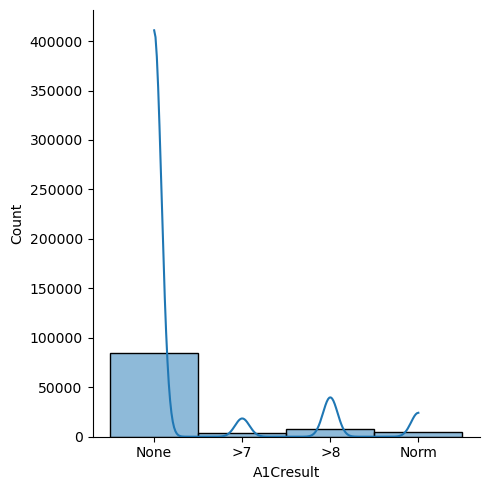

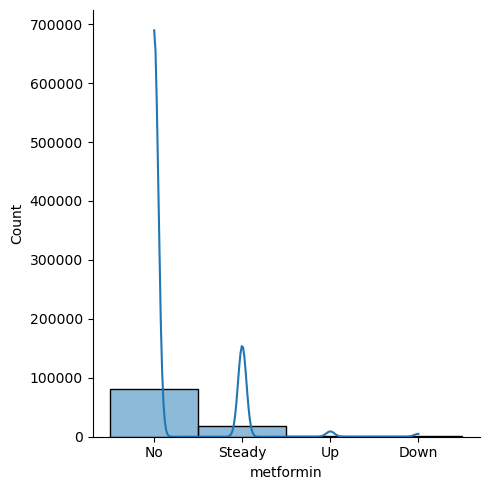

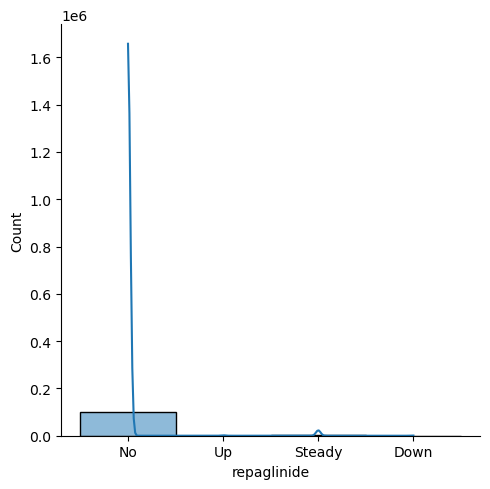

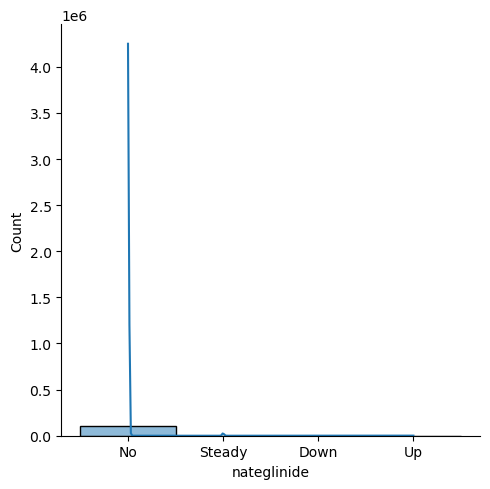

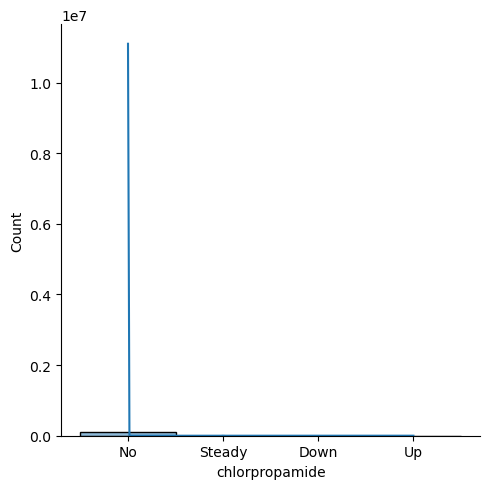

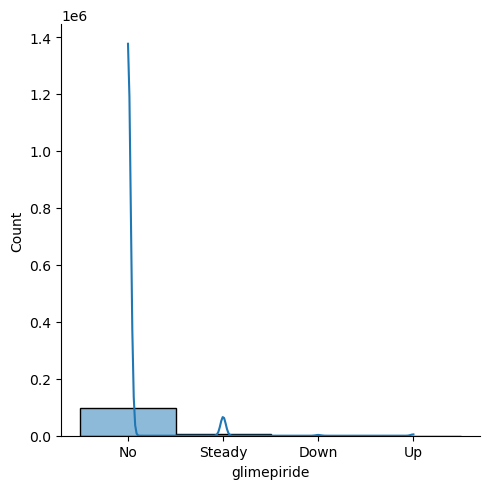

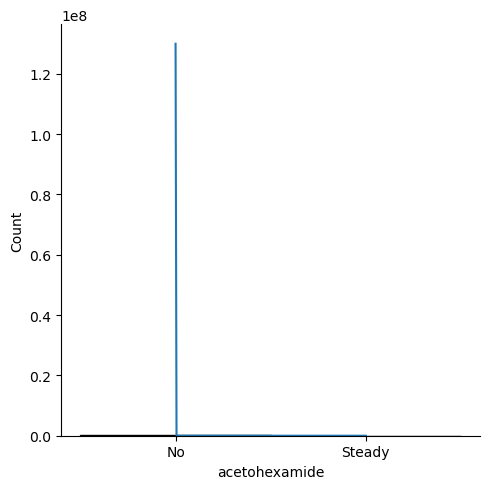

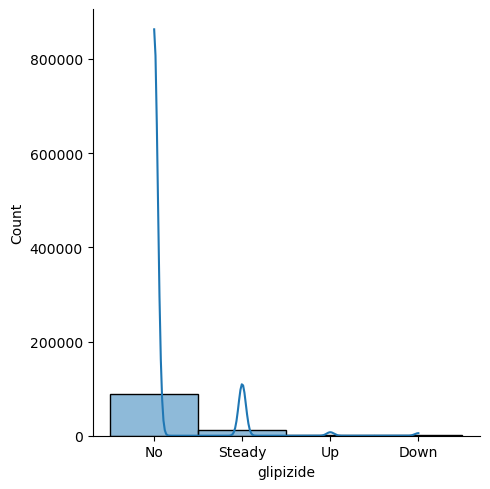

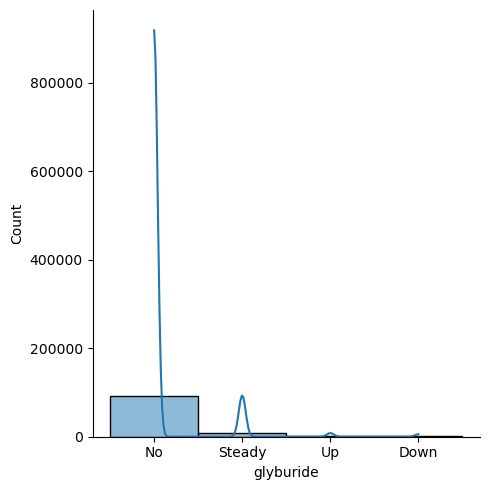

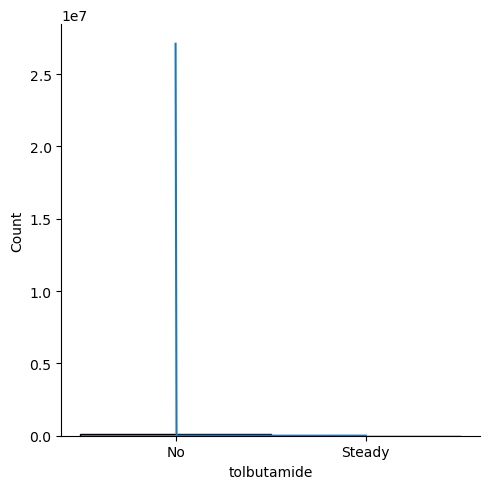

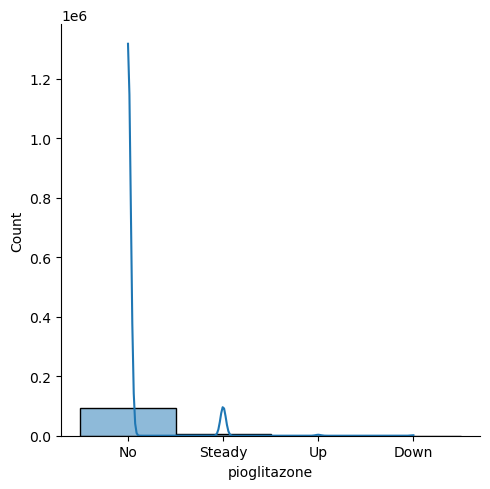

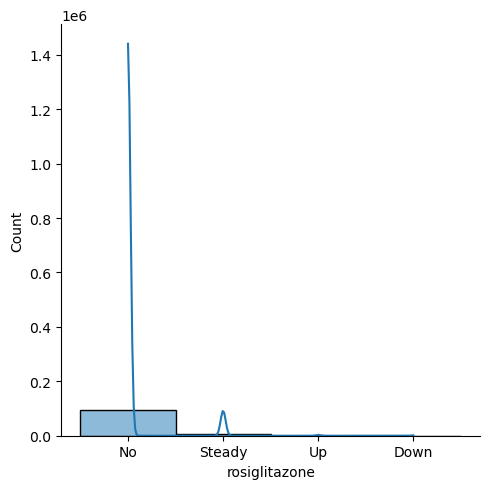

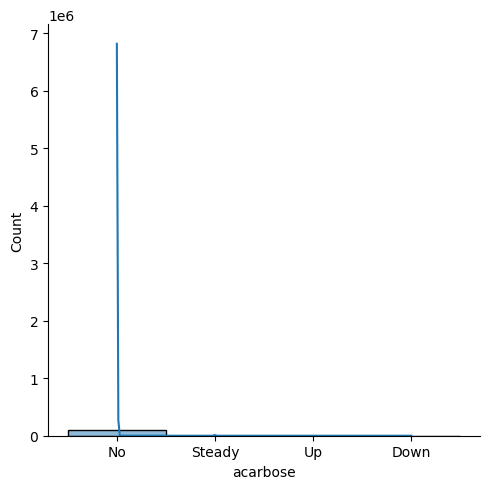

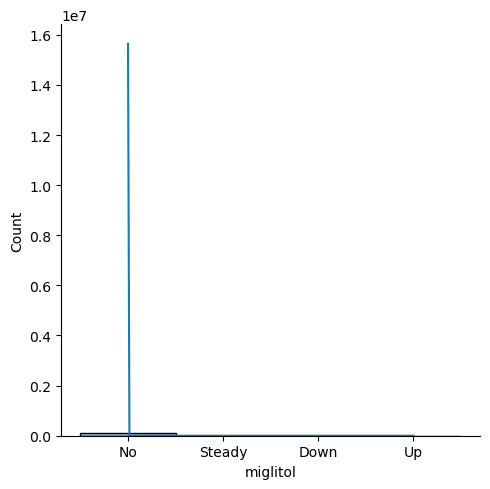

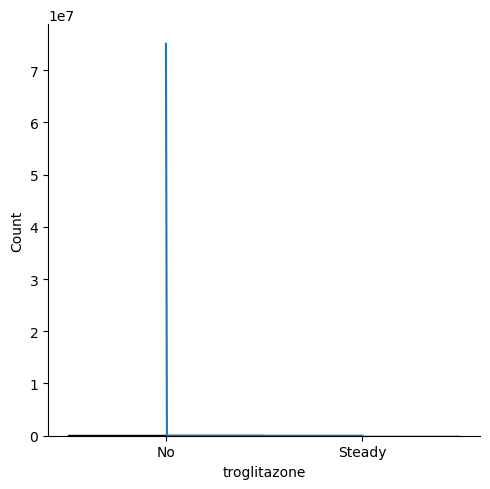

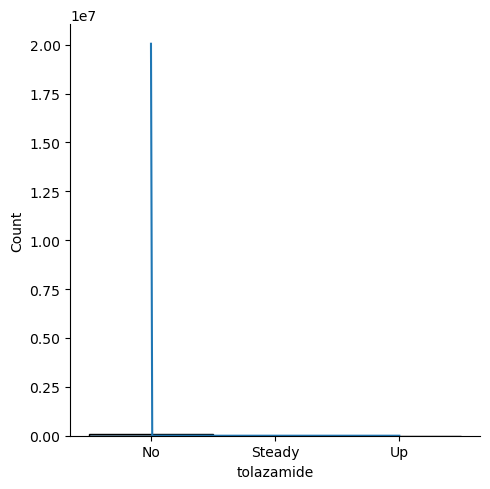

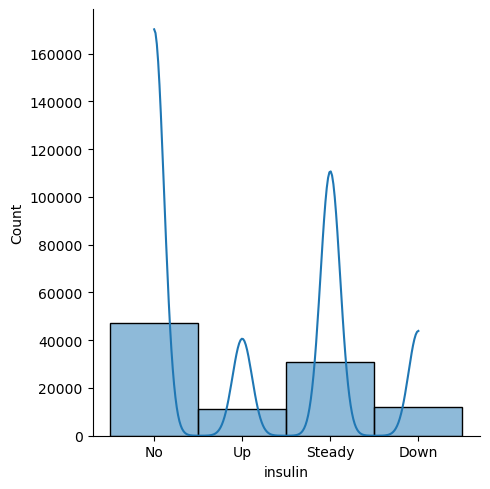

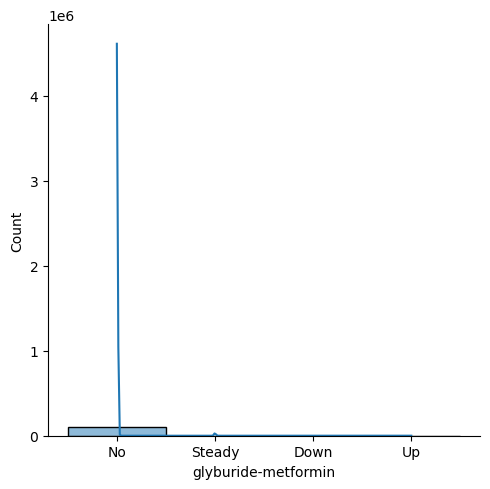

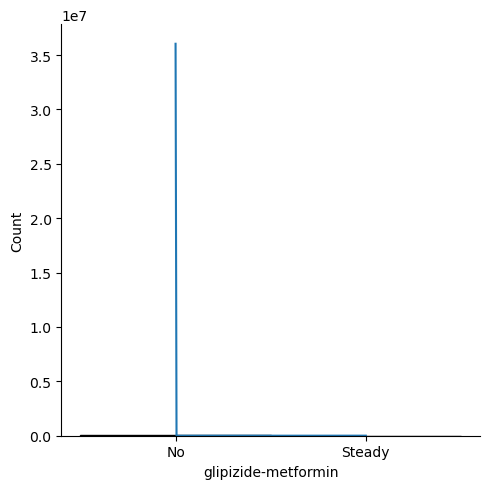

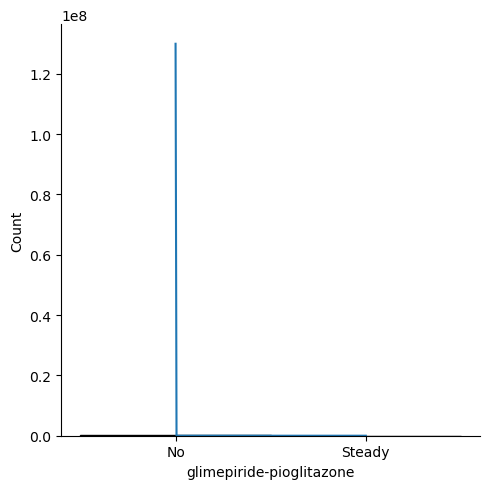

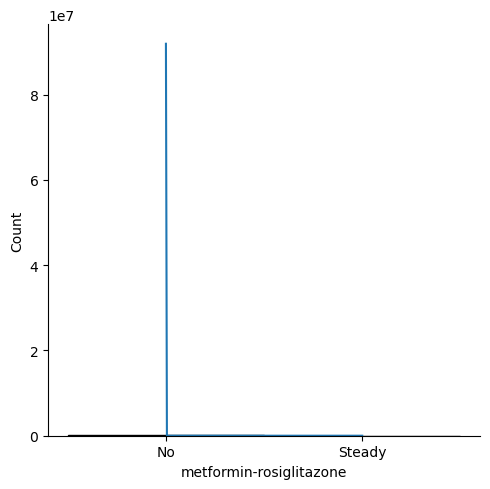

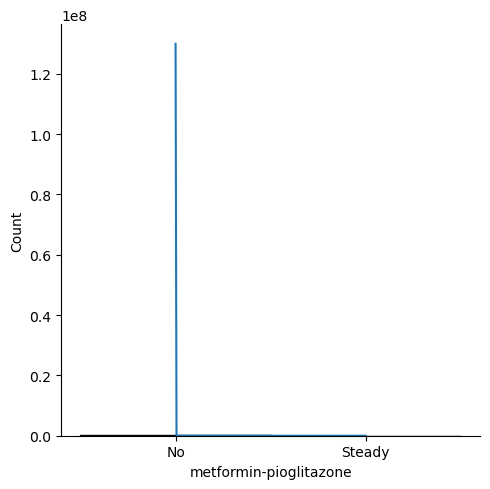

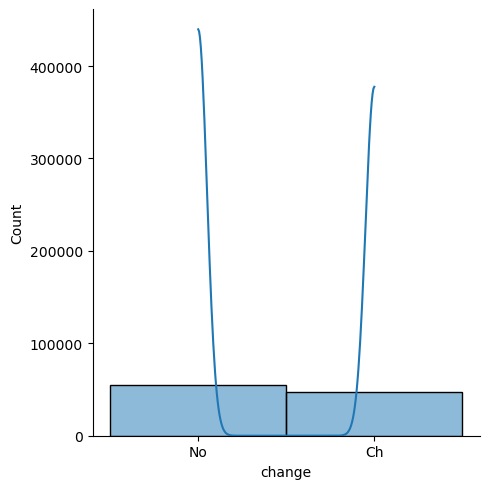

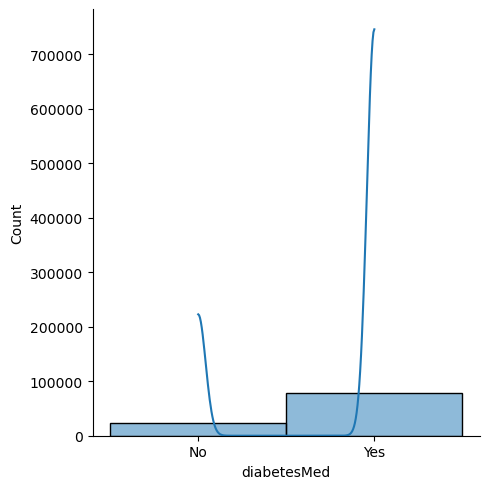

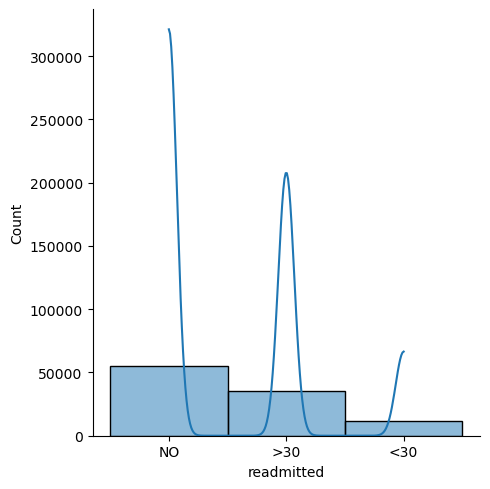

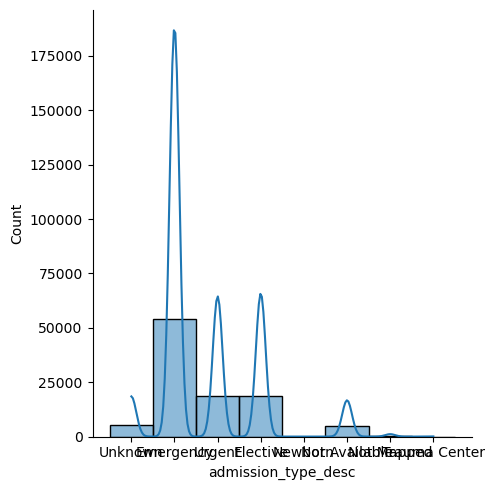

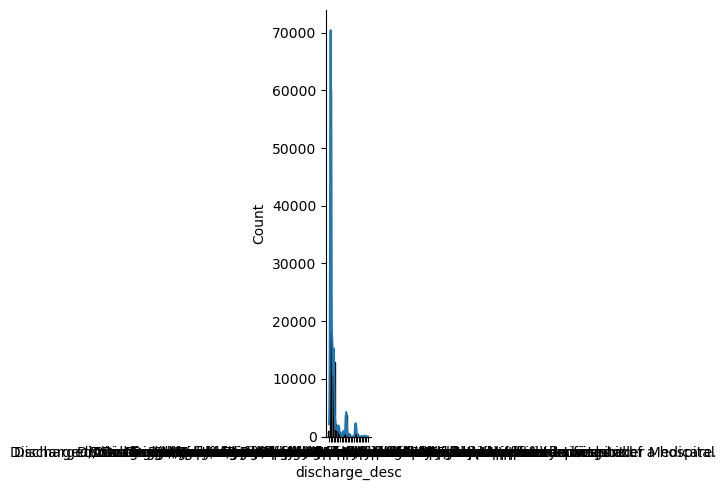

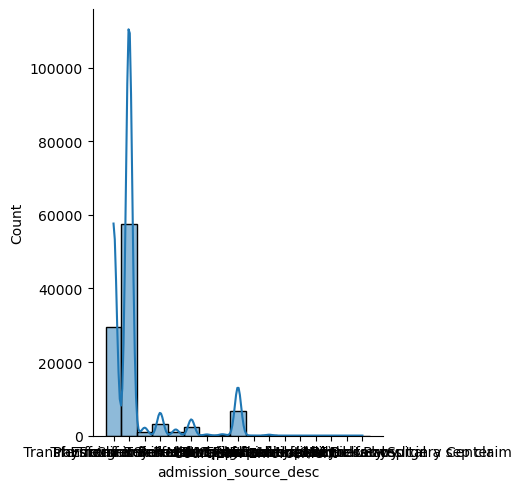

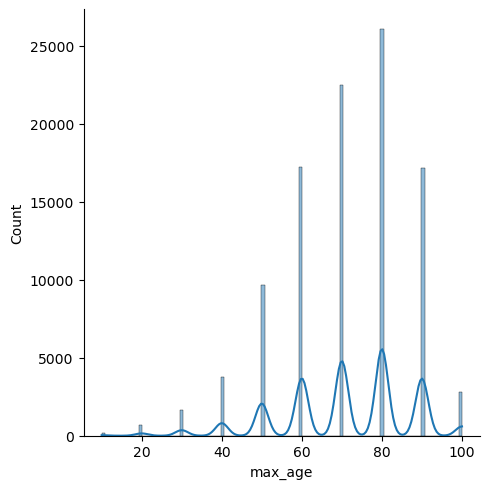

In [27]:
for i in diabetes.columns:
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize(10, 20))
    sns.displot(diabetes[i], kde=True)
    plt.show()

## Imputation

### `medical_speciality`
- 45% missing values
- categorical dtype
- imputation method: 

In [28]:
# plot_categorical_proportions(df=model_df, 
#                              grouping_variable_list=["race", "gender"], response_variable="readmitted",
#                              response_success_level="NO")

### `payer_code`
- 40% missing values
- categorical dtype
- imputation method: 

In [29]:
diabetes.payer_code.value_counts(normalize=True)

MC    0.527378
HM    0.102000
SP    0.081401
BC    0.075679
MD    0.057422
CP    0.041180
UN    0.039798
CM    0.031491
OG    0.016794
PO    0.009624
DM    0.008925
CH    0.002374
WC    0.002195
OT    0.001544
MP    0.001284
SI    0.000894
FR    0.000016
Name: payer_code, dtype: float64

### `race`
- 2% missing values
- categorical dtype
- imputation method: 

In [30]:
diabetes.race.value_counts(normalize=True)

Caucasian          0.764868
AfricanAmerican    0.193079
Hispanic           0.020474
Other              0.015137
Asian              0.006443
Name: race, dtype: float64

### `diag_3`
- Additional secondary diagnosis; 789 distinct values
- 1.4% missing values
- numerical dtype
- imputation method: 

In [31]:
diabetes.diag_3.nunique()

789

In [32]:
diabetes.diag_3.value_counts(normalize=True)

250     0.115155
401     0.082607
276     0.051573
428     0.045614
427     0.039415
          ...   
657     0.000010
684     0.000010
603     0.000010
E826    0.000010
971     0.000010
Name: diag_3, Length: 789, dtype: float64

### `diag_2`
- Secondary dignosis; 748 distinct values
- 0.35% missing values
- numerical dtype
- imputation method: 

In [33]:
diabetes.diag_2.nunique()

748

In [34]:
diabetes.diag_2.value_counts(normalize=True)

276     0.066583
428     0.065695
250     0.059867
427     0.049661
401     0.036841
          ...   
232     0.000010
908     0.000010
52      0.000010
E817    0.000010
927     0.000010
Name: diag_2, Length: 748, dtype: float64

### `diag_1`
- The primary diagnosis; 716 distinct values
- 0.02% missing values
- numerical dtype
- imputation method: 

In [35]:
diabetes.diag_1.nunique()

716

In [36]:
diabetes.diag_1.value_counts(normalize=True)

428    0.067443
414    0.064681
786    0.039471
410    0.035520
486    0.034478
         ...   
817    0.000010
61     0.000010
148    0.000010
870    0.000010
V51    0.000010
Name: diag_1, Length: 716, dtype: float64

train_df# Modeling
- Scaler used:
- Imputation methods used:
- Summary stats after imputation

In [37]:
model_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'max_age'],
      dtype='object')

In [38]:
# encounter_id --> Int --> should be encoded?
model_df["encounter_id"].nunique()

# patient_nbr --> Int --> should be encoded?
model_df["patient_nbr"].unique()

# Only three "Unknown/Invalid" observations --> Drop these?
model_df["gender"].value_counts()

# These are going into the model as integers... does that really make sense? 
# They seem like categorical things, encode? 
model_df["admission_source_id"].unique()
model_df["admission_type_id"].unique()
model_df["discharge_disposition_id"].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

In [39]:
# train test split
# cross validation with training --> pick model
# with picked model, test 
train_df, test_df = train_test_split(model_df,
                                     test_size=0.05, 
                                     stratify=model_df["readmitted"],
                                     random_state=77)

In [40]:
X_train, y_train = train_df.drop(columns="readmitted"), train_df["readmitted"]
X_test, y_test = test_df.drop(columns="readmitted"), test_df["readmitted"]

In [41]:
# TODO: pipeline without encoder, plot after imputing

numeric_pipeline = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")),
                                   ('scaler', PowerTransformer(method="yeo-johnson"))])

nominal_pipeline = Pipeline(steps=[('nom_imputer', SimpleImputer(strategy="most_frequent")), 
                                   ('nom_encoder', OneHotEncoder(handle_unknown="infrequent_if_exist"))])


preprocess = ColumnTransformer(transformers=[("num", numeric_pipeline, selector(dtype_include=int)), 
                                             ("cat", nominal_pipeline, selector(dtype_include=object))],
                               remainder="passthrough",
                               sparse_threshold=0.3)

model = Pipeline(steps=[("preprocess", preprocess), 
                        ("logreg", LogisticRegression(random_state=77, 
                                                      solver="saga",
                                                      multi_class="multinomial", 
                                                      max_iter=10_000))])

In [42]:
## Baseline model
cv_results = cross_validate(estimator=model, 
                            X=X_train,
                            y=y_train, 
                            cv=StratifiedKFold(n_splits=5, 
                                               shuffle=True, 
                                               random_state=77), 
                            return_train_score=True, 
                            return_estimator=True,
                            scoring=["accuracy", 
                                     "f1_weighted", 
                                     "precision_weighted"], 
                            error_score="raise")

coef_df = pd.DataFrame({"parameter":cv_results['estimator'][0][:-1].get_feature_names_out(),
                        "model1_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[0,:], 
                        "model2_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[1,:],
                        "model3_coefs":cv_results['estimator'][0].named_steps["logreg"].coef_[2,:]})

model1_coef_df = coef_df.reindex(coef_df["model1_coefs"].abs().sort_values(ascending=False).index)
model2_coef_df = coef_df.reindex(coef_df["model2_coefs"].abs().sort_values(ascending=False).index)
model3_coef_df = coef_df.reindex(coef_df["model3_coefs"].abs().sort_values(ascending=False).index)

print(f"Train Accuracy: {cv_results['train_accuracy']}")
print(f"Test Accuracy: {cv_results['test_accuracy']}")

Train Accuracy: [0.58297669 0.58300255 0.58236146 0.58245197 0.5833829 ]
Test Accuracy: [0.58057509 0.581506   0.58469097 0.58174295 0.57755366]


In [43]:
y_train.value_counts(normalize=True)

NO     0.539115
>30    0.349287
<30    0.111598
Name: readmitted, dtype: float64

In [44]:
%%time

reg_strength = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3, 1.5, 2.0, 2.5, 5.0, 10.0]

parameter_grid = [{"logreg__penalty":["l1", "l2"], 
                   "logreg__class_weight":['balanced', None],
                   "logreg__C":reg_strength}, 
                  {"logreg__penalty":["elasticnet"], 
                   "logreg__class_weight":["balanced", None], 
                   "logreg__C":reg_strength, 
                   "logreg__l1_ratio":[0.25, 0.5, 0.75]}]

gs = run_gridsearch(X=X_train, 
                    y=y_train, 
                    estimator=model, 
                    param_grid=parameter_grid, 
                    save_name=get_gs_save_name(model_name="logreg"))

gs_df = pd.DataFrame(gs.cv_results_)

#g = load_gs_from_pickle(pickle_filepath="./models/lasso_20220904_0642_gs.pkl")

Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: total: 2min 49s
Wall time: 3h 16min 9s


In [48]:
gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__l1_ratio,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,split0_test_precision_weighted,split1_test_precision_weighted,split2_test_precision_weighted,split3_test_precision_weighted,split4_test_precision_weighted,mean_test_precision_weighted,std_test_precision_weighted,rank_test_precision_weighted,split0_train_precision_weighted,split1_train_precision_weighted,split2_train_precision_weighted,split3_train_precision_weighted,split4_train_precision_weighted,mean_train_precision_weighted,std_train_precision_weighted
0,114.727001,72.000298,0.742234,0.181460,0.1,balanced,l1,NaN,"{'logreg__C': 0.1, 'logreg__class_weight': 'ba...",0.489553,0.491363,0.484924,0.493251,0.486941,0.489206,0.002987,66,0.490581,0.489585,0.490510,0.489630,0.491906,0.490442,0.000844,0.507056,0.509665,0.503167,0.510305,0.504562,0.506951,0.002780,69,0.508971,0.507258,0.507877,0.507345,0.508817,0.508054,0.000719,0.545608,0.552185,0.544032,0.549487,0.544853,0.547233,0.003103,15,0.548583,0.547345,0.548016,0.548061,0.548348,0.548071,0.000417
1,15.731192,0.466003,0.685600,0.018554,0.1,balanced,l2,NaN,"{'logreg__C': 0.1, 'logreg__class_weight': 'ba...",0.490536,0.490329,0.483320,0.492061,0.486010,0.488451,0.003262,72,0.490969,0.489391,0.491273,0.489850,0.491505,0.490598,0.000828,0.508725,0.509195,0.502366,0.509963,0.504522,0.506954,0.002972,68,0.509969,0.507786,0.509373,0.508203,0.509213,0.508909,0.000799,0.547498,0.551609,0.543681,0.549396,0.544915,0.547420,0.002889,2,0.549756,0.548053,0.549784,0.548944,0.549018,0.549111,0.000636
2,393.434132,115.475179,0.749464,0.069579,0.1,None,l1,NaN,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",0.579386,0.583006,0.581019,0.582622,0.579157,0.581038,0.001591,30,0.582227,0.581348,0.581624,0.581547,0.582465,0.581842,0.000428,0.524280,0.529360,0.526780,0.528338,0.524837,0.526719,0.001954,64,0.528096,0.526725,0.527539,0.526895,0.528684,0.527588,0.000733,0.499940,0.504701,0.502503,0.503773,0.500489,0.502281,0.001834,129,0.503696,0.558353,0.502910,0.502838,0.503900,0.514339,0.022011
3,12.952395,0.426897,0.714482,0.070272,0.1,None,l2,NaN,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",0.580317,0.581713,0.581743,0.581640,0.580398,0.581162,0.000658,7,0.582679,0.581800,0.581909,0.582103,0.583215,0.582341,0.000532,0.525828,0.528810,0.527814,0.528119,0.526642,0.527443,0.001069,55,0.529285,0.527798,0.528375,0.528102,0.529905,0.528693,0.000784,0.538487,0.503572,0.540709,0.577334,0.501894,0.532399,0.027881,68,0.546209,0.551026,0.525723,0.519588,0.538222,0.536153,0.011915
4,326.225121,152.601174,0.658424,0.014537,0.3,balanced,l1,NaN,"{'logreg__C': 0.3, 'logreg__class_weight': 'ba...",0.489501,0.490381,0.483320,0.493251,0.485855,0.488462,0.003491,71,0.490826,0.489417,0.490768,0.489566,0.491596,0.490435,0.000825,0.507518,0.509078,0.502347,0.511055,0.504077,0.506815,0.003195,72,0.509729,0.507666,0.508735,0.507772,0.509189,0.508618,0.000800,0.546235,0.551590,0.543955,0.550531,0.544334,0.547329,0.003161,6,0.549544,0.547782,0.549064,0.548415,0.548941,0.548749,0.000602


# Feature Importance

In [45]:
model1_coef_df.head()

,parameter,model1_coefs,model2_coefs,model3_coefs
75,cat__medical_specialty_Pediatrics-Endocrinology,-1.202482,0.211954,0.990528
38,cat__medical_specialty_AllergyandImmunology,1.131051,-0.152407,-0.978644
68,cat__medical_specialty_Otolaryngology,-0.935062,0.271572,0.663490
52,cat__medical_specialty_Hematology,0.924014,-0.340876,-0.583137
51,cat__medical_specialty_Gynecology,-0.803400,0.100021,0.703379


In [46]:
model2_coef_df.head()

,parameter,model1_coefs,model2_coefs,model3_coefs
79,cat__medical_specialty_Pediatrics-Pulmonology,-0.266848,1.083172,-0.816324
72,cat__medical_specialty_Pediatrics-AllergyandIm...,-0.271526,0.843250,-0.571725
44,cat__medical_specialty_Dentistry,-0.177427,0.828266,-0.650840
76,cat__medical_specialty_Pediatrics-Hematology-O...,0.300154,-0.785844,0.485690
86,cat__medical_specialty_Psychiatry-Child/Adoles...,0.485514,-0.683144,0.197631


In [47]:
model3_coef_df.head()

,parameter,model1_coefs,model2_coefs,model3_coefs
75,cat__medical_specialty_Pediatrics-Endocrinology,-1.202482,0.211954,0.990528
38,cat__medical_specialty_AllergyandImmunology,1.131051,-0.152407,-0.978644
79,cat__medical_specialty_Pediatrics-Pulmonology,-0.266848,1.083172,-0.816324
51,cat__medical_specialty_Gynecology,-0.803400,0.100021,0.703379
168,cat__miglitol_Down,0.451516,0.239490,-0.691006


# References/Links
- Research paper/data dictionary: https://www.hindawi.com/journals/bmri/2014/781670/
- https://scikit-learn.org/stable/modules/impute.html
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py